In [204]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import keras_tuner
from tensorflow.keras.models import load_model




In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
data_path = r'/content/drive/MyDrive/RealWaste'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),



)


Found 4752 files belonging to 9 classes.


In [15]:
class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [164]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomCrop(224, 224),
])

def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label



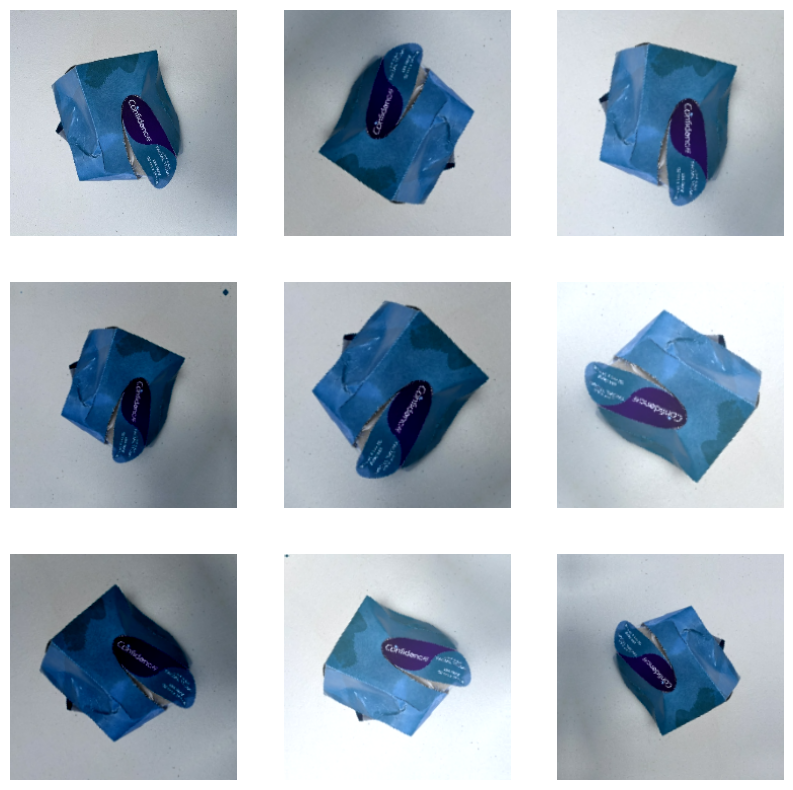

In [165]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]


    augmented_images = [image]
    for _ in range(8):
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])


    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")

    plt.show()


visualize_dataset(dataset, class_names)

In [166]:

def normalize_and_encode(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label


In [167]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [168]:

train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size


train_dataset = dataset.take(train_size).map(augment).map(normalize_and_encode)
remaining_dataset = dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size).map(normalize_and_encode)
test_dataset = remaining_dataset.skip(val_size).map(normalize_and_encode)

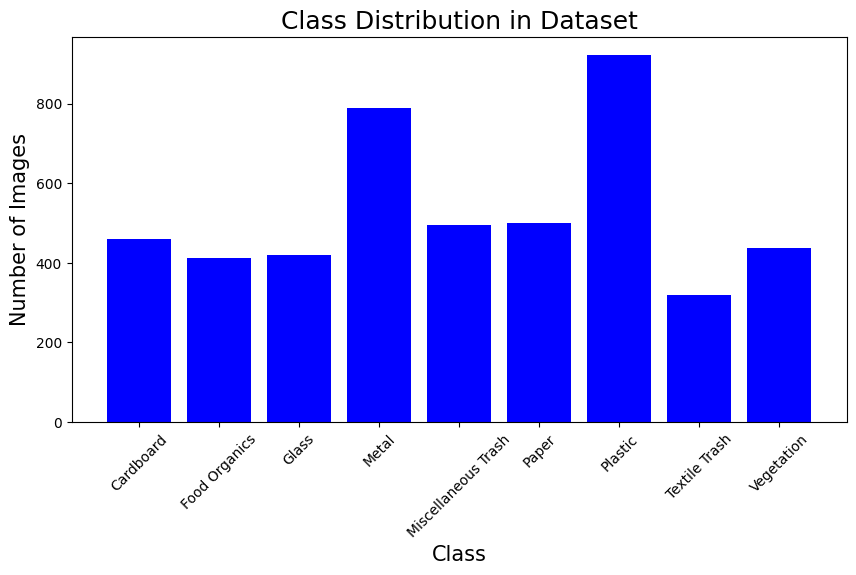

In [169]:



class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}


plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [170]:

train_labels = []


for batch in train_dataset.as_numpy_iterator():
    labels = batch[1]


    if labels.ndim > 1:
        labels = np.argmax(labels, axis=1)

    train_labels.extend(labels)


train_labels = np.array(train_labels)


class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}


print("Class weights:", class_weights_dict)


Class weights: {0: np.float64(1.1171534071836187), 1: np.float64(1.2534839924670433), 2: np.float64(1.2325925925925927), 3: np.float64(0.6353570064910271), 4: np.float64(1.090789904949197), 5: np.float64(1.0534979423868314), 6: np.float64(0.5954553587403829), 7: np.float64(1.7360459050599895), 8: np.float64(1.2492492492492493)}


In [172]:

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal loss for multi-class classification with one-hot labels.
    """
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)

    return loss

In [177]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:

        return float(lr * tf.math.exp(-0.1))


In [178]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [179]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False




model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dense(9, activation="softmax")
])


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss= categorical_focal_loss(),
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss",
                               patience=3,
                               restore_best_weights=True,
                               verbose=1)
lr_scheduler = LearningRateScheduler(scheduler)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=20,  callbacks=[early_stopping, lr_scheduler, reduce_lr])



Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 69s 483ms/step - accuracy: 0.1175 - loss: 0.5108 - val_accuracy: 0.0909 - val_loss: 0.4302 - learning_rate: 1.0000e-04
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - accuracy: 0.1476 - loss: 0.4666 - val_accuracy: 0.2244 - val_loss: 0.4266 - learning_rate: 1.0000e-04
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 445ms/step - accuracy: 0.1597 - loss: 0.4602 - val_accuracy: 0.2301 - val_loss: 0.4249 - learning_rate: 1.0000e-04
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 47s 452ms/step - accuracy: 0.1491 - loss: 0.4569 - val_accuracy: 0.2259 - val_loss: 0.4224 - learning_rate: 1.0000e-04
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 47s 448ms/step - accuracy: 0.1673 - loss: 0.4540 - val_accuracy: 0.2131 - val_loss: 0.4227 - learning_rate: 1.0000e-04
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 442ms/step - accuracy: 0.1615 - loss: 0.4528 - val_accuracy: 0.2188 - val_loss: 0.4220 - learning_rate: 9.0484e-05
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 43

In [180]:

y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds)

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)


y_pred = np.argmax(y_pred_probs, axis=1)

print("True labels shape:", y_true.shape)
print("Predicted labels shape:", y_pred.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
True labels shape: (704, 9)
Predicted labels shape: (704,)


In [181]:


if y_pred.ndim > 1:
    y_pred = np.argmax(y_pred, axis=1)


if y_true.ndim > 1:
    y_true = np.argmax(y_true, axis=1)


print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.00      0.00      0.00        53
           2       0.00      0.00      0.00        59
           3       0.15      0.02      0.04       100
           4       0.00      0.00      0.00        84
           5       0.00      0.00      0.00        67
           6       0.21      0.99      0.35       147
           7       0.00      0.00      0.00        53
           8       0.00      0.00      0.00        71

    accuracy                           0.21       704
   macro avg       0.04      0.11      0.04       704
weighted avg       0.07      0.21      0.08       704



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [182]:

base_model.trainable = True
for layer in base_model.layers[:-25]:
    layer.trainable = True


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss= categorical_focal_loss(),
              metrics=["accuracy"])


history_fine_tune = model.fit(train_dataset, validation_data=val_dataset, epochs=30, class_weight=class_weights_dict, callbacks=[ lr_scheduler, reduce_lr])

Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 115s 456ms/step - accuracy: 0.1058 - loss: 0.6515 - val_accuracy: 0.0895 - val_loss: 0.4833 - learning_rate: 1.0000e-05
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 47s 449ms/step - accuracy: 0.1775 - loss: 0.5524 - val_accuracy: 0.1065 - val_loss: 0.4755 - learning_rate: 1.0000e-05
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 441ms/step - accuracy: 0.2389 - loss: 0.4731 - val_accuracy: 0.1520 - val_loss: 0.4931 - learning_rate: 1.0000e-05
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 439ms/step - accuracy: 0.2904 - loss: 0.4164 - val_accuracy: 0.1605 - val_loss: 0.5087 - learning_rate: 1.0000e-05
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 442ms/step - accuracy: 0.3364 - loss: 0.3823 - val_accuracy: 0.2060 - val_loss: 0.4506 - learning_rate: 1.0000e-05
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 48s 459ms/step - accuracy: 0.3735 - loss: 0.3538 - val_accuracy: 0.2614 - val_loss: 0.3885 - learning_rate: 9.0484e-06
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 4

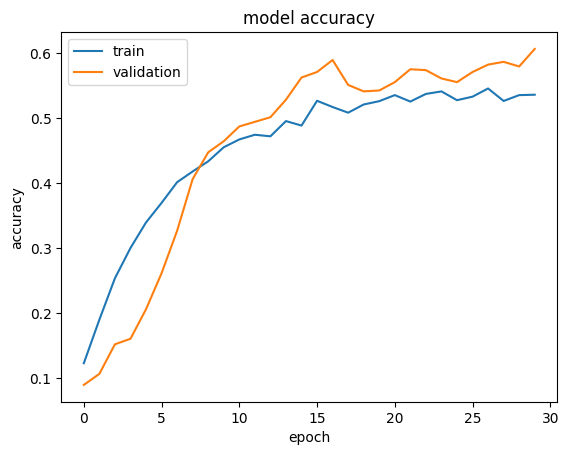

In [183]:
def plot_hist(history_fine_tune):
    plt.plot(history_fine_tune.history["accuracy"])
    plt.plot(history_fine_tune.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history_fine_tune)

In [184]:

y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds)

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)


y_pred = np.argmax(y_pred_probs, axis=1)

print("True labels shape:", y_true.shape)
print("Predicted labels shape:", y_pred.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
True labels shape: (704, 9)
Predicted labels shape: (704,)


In [185]:

if y_pred.ndim > 1:
    y_pred = np.argmax(y_pred, axis=1)


if y_true.ndim > 1:
    y_true = np.argmax(y_true, axis=1)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.56      0.58        64
           1       0.57      0.71      0.63        51
           2       0.54      0.68      0.61        63
           3       0.51      0.53      0.52        92
           4       0.51      0.31      0.38        78
           5       0.48      0.58      0.53        73
           6       0.70      0.43      0.54       164
           7       0.55      0.73      0.63        52
           8       0.59      0.88      0.71        67

    accuracy                           0.57       704
   macro avg       0.56      0.60      0.57       704
weighted avg       0.58      0.57      0.56       704



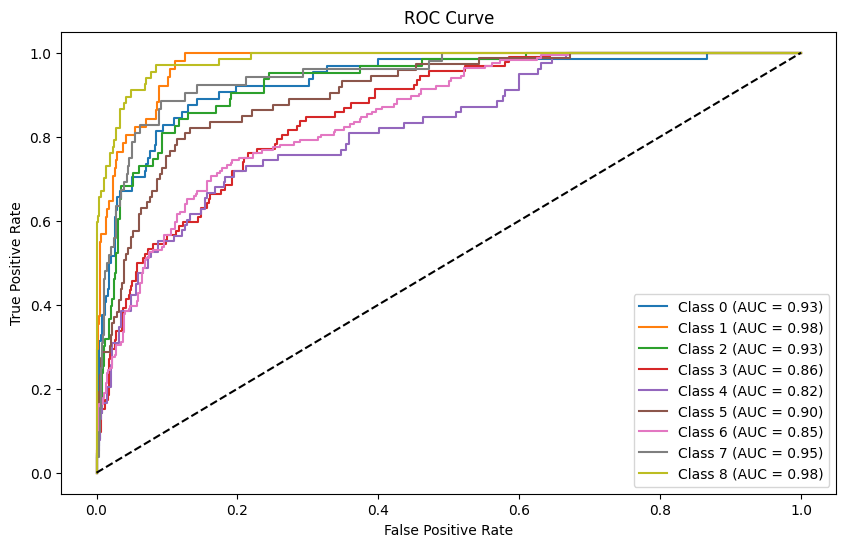

In [186]:

num_classes = 9
y_true_one_hot = to_categorical(y_true, num_classes)


plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

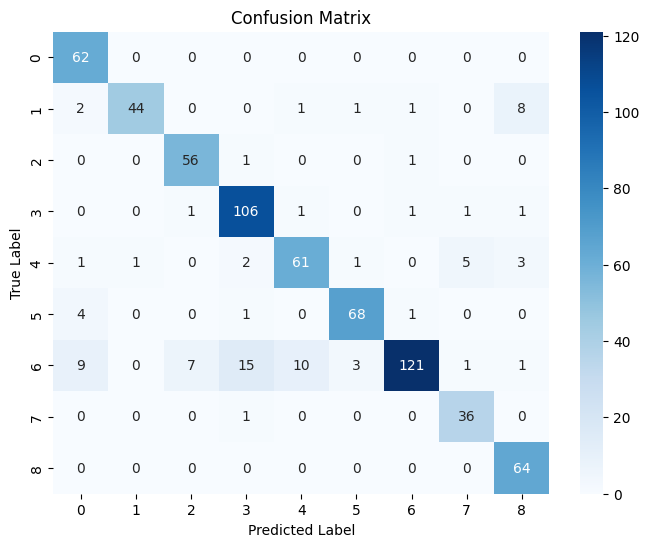

In [213]:



cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [188]:


def build_model(hp):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    trainable = hp.Boolean('trainable', default=False)
    base_model.trainable = trainable

    if trainable:
        num_unfrozen_layers = hp.Int("unfreeze_layers", min_value=10, max_value=30, step=5)
        for layer in base_model.layers[-num_unfrozen_layers:]:
            layer.trainable = True

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(hp.Float("dropout_rate", min_value=0.3, max_value=0.7, step=0.1)),
        layers.Dense(hp.Int("units", min_value=128, max_value=512, step=64),
                     activation=hp.Choice("activation", ["relu", "elu", "swish"])),
        layers.Dense(9, activation="softmax")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", [1e-3, 1e-4, 1e-5, 1e-6])),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [189]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    directory="hyperparameter_tuning",
    project_name="efficientnet_tuning"
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

In [190]:
tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping, lr_scheduler])


best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]




Trial 3 Complete [00h 14m 04s]
val_accuracy: 0.3302556946873665

Best val_accuracy So Far: 0.3302556946873665
Total elapsed time: 00h 44m 53s
Best hyperparameters:


NameError: name 'best_hps' is not defined

In [195]:
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[ lr_scheduler]
)


Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 112s 466ms/step - accuracy: 0.4793 - loss: 1.9917 - val_accuracy: 0.0838 - val_loss: 4.8564 - learning_rate: 0.0010
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 438ms/step - accuracy: 0.6601 - loss: 1.0751 - val_accuracy: 0.1023 - val_loss: 4.3897 - learning_rate: 0.0010
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 442ms/step - accuracy: 0.7241 - loss: 0.8443 - val_accuracy: 0.0838 - val_loss: 2.6374 - learning_rate: 0.0010
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 442ms/step - accuracy: 0.7530 - loss: 0.6905 - val_accuracy: 0.0881 - val_loss: 5.9427 - learning_rate: 0.0010
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.7740 - loss: 0.6439
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 438ms/step - accuracy: 0.7741 - loss: 0.6436 - val_accuracy: 0.1264 - val_loss: 3.1468 - learning_rate: 0.0010
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 442ms/step - accuracy: 0.82

In [196]:
tuner.results_summary()


Results summary
Results in hyperparameter_tuning/efficientnet_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
trainable: True
dropout_rate: 0.3
units: 256
activation: elu
learning_rate: 0.001
unfreeze_layers: 10
Score: 0.3302556946873665

Trial 1 summary
Hyperparameters:
trainable: False
dropout_rate: 0.5
units: 512
activation: elu
learning_rate: 0.001
Score: 0.2478693202137947

Trial 0 summary
Hyperparameters:
trainable: False
dropout_rate: 0.6000000000000001
units: 192
activation: elu
learning_rate: 1e-06
Score: 0.17045454680919647


In [197]:
from sklearn.metrics import classification_report


y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_probs.extend(preds)


y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)


y_pred = np.argmax(y_pred_probs, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [198]:


print(classification_report(y_true, y_pred, zero_division=0))


              precision    recall  f1-score   support

           0       0.79      1.00      0.89        62
           1       0.98      0.77      0.86        57
           2       0.88      0.97      0.92        58
           3       0.84      0.95      0.89       111
           4       0.84      0.82      0.83        74
           5       0.93      0.92      0.93        74
           6       0.97      0.72      0.83       167
           7       0.84      0.97      0.90        37
           8       0.83      1.00      0.91        64

    accuracy                           0.88       704
   macro avg       0.88      0.90      0.88       704
weighted avg       0.89      0.88      0.88       704



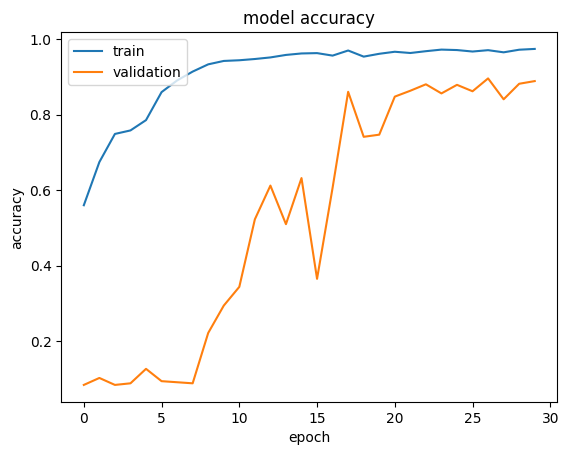

In [212]:
def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

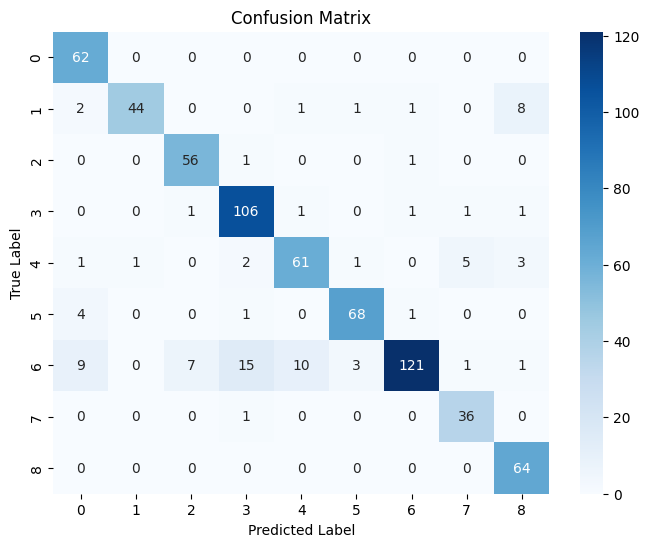

In [214]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [208]:
best_model.save("best_efficientnet_model.keras", include_optimizer=False)


In [209]:
model = load_model("best_efficientnet_model.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - accuracy: 0.8754 - loss: 0.4825
Test Accuracy: 0.8736
Test Loss: 0.4703
